# MVA - Mini-Project 1 
#####  Ali M'RABETH 

##### We importe provided code as well as some keras functions

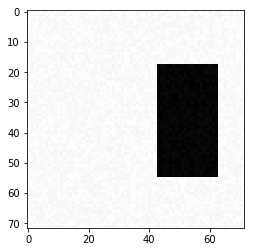

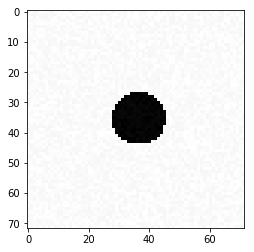

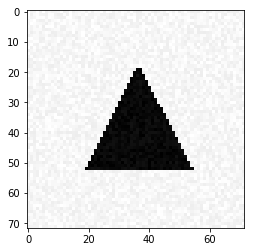

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    #Y_test = np_utils.to_categorical(Y_test, 3) 
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout,Flatten, UpSampling2D,Activation, LeakyReLU#, advanced_activations
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

# 3 - Simple Linear Classifier

We importe data, and transform the response variable to a matrix of dummy variables

In [8]:
[X_train, Y_train] = generate_dataset_classification(300, 20);
target = to_categorical(Y_train)
nb_features = X_train.shape[1]
nb_class = target.shape[1]

Creating data:
0
100
200


We train a linear classifier, using the **Adam Optimizer**, and 30 epochs

In [21]:
model_adam = Sequential()
model_adam.add(Dense(nb_class, activation='softmax', input_shape=(nb_features,)))
model_adam.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(patience=3)
model_adam.fit(X_train, target, validation_split=0.2, epochs=30, callbacks= [early_stop]);

Train on 240 samples, validate on 60 samples
Epoch 1/30
240/240 [==============================] - 1s 4ms/step - loss: 1.9890 - acc: 0.3292 - val_loss: 1.0668 - val_acc: 0.4500
Epoch 2/30
240/240 [==============================] - 0s 239us/step - loss: 1.4201 - acc: 0.4417 - val_loss: 1.4684 - val_acc: 0.4000
Epoch 3/30
240/240 [==============================] - 0s 224us/step - loss: 0.8687 - acc: 0.6083 - val_loss: 1.0136 - val_acc: 0.3833
Epoch 4/30
240/240 [==============================] - 0s 239us/step - loss: 0.7332 - acc: 0.6583 - val_loss: 0.5181 - val_acc: 0.7333
Epoch 5/30
240/240 [==============================] - 0s 217us/step - loss: 0.5763 - acc: 0.7292 - val_loss: 0.4120 - val_acc: 0.8333
Epoch 6/30
240/240 [==============================] - 0s 227us/step - loss: 0.4009 - acc: 0.8500 - val_loss: 0.3519 - val_acc: 0.9000
Epoch 7/30
240/240 [==============================] - 0s 253us/step - loss: 0.2993 - acc: 0.9625 - val_loss: 0.3051 - val_acc: 0.9333
Epoch 8/30
240/240 

We train a linear classifier, using **SGD** Optimizer instead

In [25]:
model_sgd = Sequential()
model_sgd.add(Dense(nb_class, activation='softmax', input_shape=(nb_features,)))
model_sgd.compile( optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(patience=5)
model_sgd.fit(X_train, target, validation_split=0.2, epochs=30, callbacks= [early_stop]);

Train on 240 samples, validate on 60 samples
Epoch 1/30
240/240 [==============================] - 1s 5ms/step - loss: 6.7036 - acc: 0.3583 - val_loss: 11.3441 - val_acc: 0.2833
Epoch 2/30
240/240 [==============================] - 0s 202us/step - loss: 8.4294 - acc: 0.3792 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/30
240/240 [==============================] - 0s 207us/step - loss: 9.8723 - acc: 0.3875 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 4/30
240/240 [==============================] - 0s 217us/step - loss: 9.8723 - acc: 0.3875 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 5/30
240/240 [==============================] - 0s 209us/step - loss: 9.8723 - acc: 0.3875 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 6/30
240/240 [==============================] - 0s 247us/step - loss: 9.8723 - acc: 0.3875 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 7/30
240/240 [==============================] - 0s 214us/step - loss: 9.8723 - acc: 0.3875 - val_loss: 8.8650 - val_acc: 0.4500


We test our prediciton on a dataset

In [27]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])

print(model_adam.predict(X_test))
print(model_sgd.predict(X_test))



[[0. 1. 0.]]
[[1. 0. 0.]]


**Adam optimizer has a quasi-perfect accuraccy, while the SGD optimizer perfoms worse**

# 4 - Visualization of the solution

We visualize the weights of the linear classifier with Adam optimizer, for each figure

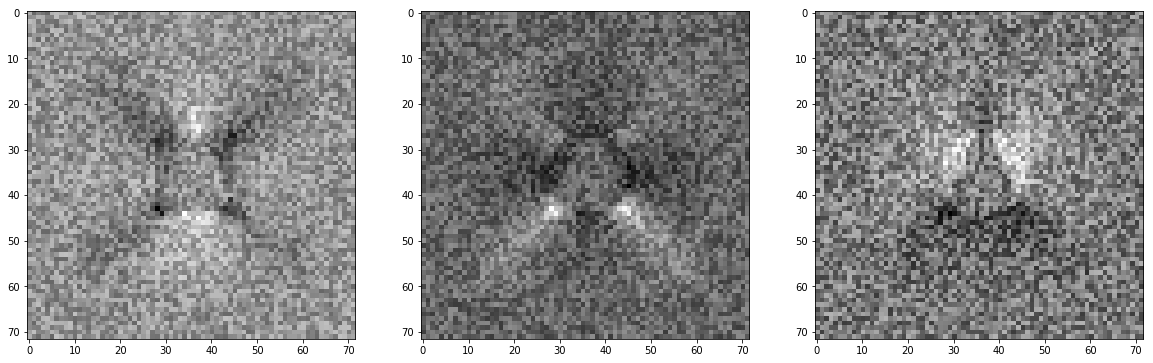

In [29]:
weights = model_adam.get_weights()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(weights[0][:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(weights[0][:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(weights[0][:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

# 5 - A more difficult classification problem

We generate a new training set, where the shapes are allowed to move within the images and change dimensions

In [30]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)
target = to_categorical(Y_train)
nb_features = X_train.shape[1]
nb_class = target.shape[1]

Creating data:
0
100
200
300
400


 We retrain the previous model, and evaluate it on a new dataset

In [34]:
model = Sequential()
model.add(Dense(nb_class, activation='softmax', input_shape=(nb_features,)))
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(patience=5)
model.fit(X_train, target, epochs=50, validation_split=0.2, callbacks=[early_stop]);

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 2s 4ms/step - loss: 2.2349 - acc: 0.4025 - val_loss: 2.0441 - val_acc: 0.3700
Epoch 2/50
400/400 [==============================] - 0s 241us/step - loss: 1.4821 - acc: 0.4375 - val_loss: 1.2634 - val_acc: 0.4900
Epoch 3/50
400/400 [==============================] - 0s 197us/step - loss: 1.0442 - acc: 0.5675 - val_loss: 1.1499 - val_acc: 0.5100
Epoch 4/50
400/400 [==============================] - 0s 202us/step - loss: 0.9319 - acc: 0.5225 - val_loss: 1.0076 - val_acc: 0.4000
Epoch 5/50
400/400 [==============================] - 0s 205us/step - loss: 0.8533 - acc: 0.5825 - val_loss: 1.0837 - val_acc: 0.5600
Epoch 6/50
400/400 [==============================] - 0s 235us/step - loss: 0.8284 - acc: 0.5950 - val_loss: 0.9444 - val_acc: 0.4700
Epoch 7/50
400/400 [==============================] - 0s 208us/step - loss: 0.7985 - acc: 0.6075 - val_loss: 1.1974 - val_acc: 0.5300
Epoch 8/50
400/400

We generate a test dataset, and evaluate our model

In [36]:
[X_test, Y_test] = generate_test_set_classification();

Creating data:
0
100
200


In [37]:
print(model.metrics_names)
res =model.evaluate(X_test, Y_test);
print("The loss on the test set is : %.2f" %res[0])
print("The accuracy on the test set is : %.2f" %res[1])

['loss', 'acc']
300/300 [==============================] - 0s 92us/step
The loss on the test set is : 1.14
The accuracy on the test set is : 0.56


#### We then train a convolutional deep network and evaluate it on the test dataset above

In [39]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
print(X_train.shape)

(500, 72, 72, 1)


In [41]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2))) 
print(model.output_shape)
model.add(Dropout(0.25))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)

## Because of overfitting issues, we remove this layer
#model.add(Dense(128, activation='relu'))
#print(model.output_shape)

model.add(Dropout(0.5)) 
model.add(Dense(3, activation='softmax')) 
print(model.output_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)
model.fit(X_train, target,
          batch_size=32, epochs=30, verbose=1,validation_split=0.2, callbacks=[early_stopping_monitor])

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 3)
Train on 400 samples, validate on 100 samples
Epoch 1/30
400/400 [==============================] - 5s 12ms/step - loss: 1.1813 - acc: 0.3950 - val_loss: 1.0362 - val_acc: 0.4800
Epoch 2/30
400/400 [==============================] - 2s 5ms/step - loss: 0.9821 - acc: 0.5225 - val_loss: 0.9642 - val_acc: 0.6200
Epoch 3/30
400/400 [==============================] - 2s 6ms/step - loss: 0.8636 - acc: 0.6750 - val_loss: 0.8788 - val_acc: 0.5800
Epoch 4/30
400/400 [==============================] - 2s 5ms/step - loss: 0.7439 - acc: 0.7325 - val_loss: 0.8162 - val_acc: 0.6200
Epoch 5/30
400/400 [==============================] - 2s 5ms/step - loss: 0.6488 - acc: 0.7575 - val_loss: 0.7594 - val_acc: 0.7000
Epoch 6/30
400/400 [==============================] - 2s 5ms/step - loss: 0.6136 - acc: 0.7875 - val_loss: 0.7611 - val_acc: 0.7000
Epoch 7/30
400/400 [==============================] - 2s 5ms/step - loss: 0.5625

We test this model on the test set above

In [42]:
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
res =model.evaluate(X_test, Y_test)
print("The loss on the test set is : %.2f" %res[0])
print("The accuracy on the test set is : %.2f" %res[1])

300/300 [==============================] - 0s 782us/step
The loss on the test set is : 0.72
The accuracy on the test set is : 0.69


In [43]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18496)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________
None


**The CNN performs better than a simple linear classifier**

# 6 - A regression problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle.
<br> Before starting, we create a function that order coordinates of vertices, from lowest to highest abscisses

In [44]:
def coordinates_sorting(Y):
    
    xx_coord = [Y[2*i] for i in range(3)]
    yy_coord = [Y[2*i+1] for i in range(3)]
    Y_sorted = []
    for i in range(3):
        
        min_index = np.argmin(xx_coord)
        Y_sorted.append(xx_coord[min_index])
        Y_sorted.append(yy_coord[min_index])
        del xx_coord[min_index]
        del yy_coord[min_index]
    return Y_sorted

We then generate a training dataset, and visualise a training sample

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


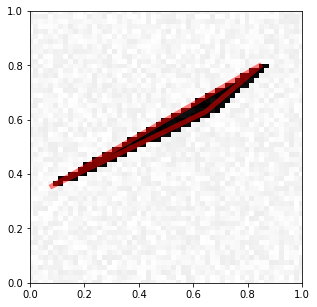

In [48]:
[X_train, Y_train] = generate_dataset_regression(2000, 20)
visualize_prediction(X_train[0], Y_train[0])

We reshape the training set 

In [49]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
print(X_train.shape)
Y_train = np.array( [ coordinates_sorting(Y_train[k]) for k in range(X_train.shape[0]) ] )

(2000, 72, 72, 1)


And train a CNN : 

In [50]:
model = Sequential()

model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model.output_shape)
model.add(Conv2D(16, (5, 5), activation='relu'))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2))) 
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)


model.add(Conv2D(16, (5, 5), activation='relu'))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2))) 
print(model.output_shape)

model.add(Dropout(0.25))

model.add(Flatten())
print(model.output_shape)

model.add(Dense(128, activation='relu'))
print(model.output_shape)

model.add(Dense(6, activation='sigmoid')) 
print(model.output_shape)
model.compile(loss='mse', optimizer='adam')
early_stopping_monitor = EarlyStopping(patience=3)
model.fit(X_train, Y_train,
          batch_size=32, epochs=20,verbose=1, validation_split=0.1, callbacks=[early_stopping_monitor])


(None, 68, 68, 16)
(None, 64, 64, 16)
(None, 32, 32, 16)
(None, 32, 32, 16)
(None, 28, 28, 16)
(None, 14, 14, 16)
(None, 3136)
(None, 128)
(None, 6)
Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 22s 12ms/step - loss: 0.0489 - val_loss: 0.0253
Epoch 2/20
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0231 - val_loss: 0.0190
Epoch 3/20
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0182 - val_loss: 0.0167
Epoch 4/20
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 5/20
1800/1800 [==============================] - 21s 12ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 6/20
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 7/20
1800/1800 [==============================] - 21s 11ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 8/20
1800/1800 [==============================] - 19s 11ms/step - loss

Let's evaluate our model and visualize some predictions

In [51]:
[X_test, Y_test] = generate_test_set_regression()
Y_pred = model.predict(X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
Y_test = np.array( [ coordinates_sorting(Y_test[k]) for k in range(Y_test.shape[0]) ] )
model.evaluate(X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

Creating data:
0
100
200
300/300 [==============================] - 1s 2ms/step


0.006586438113202651

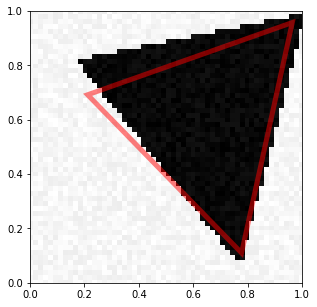

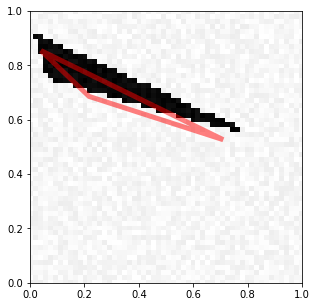

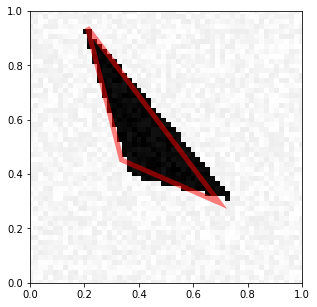

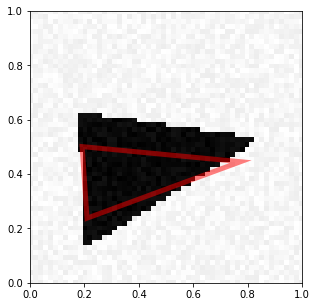

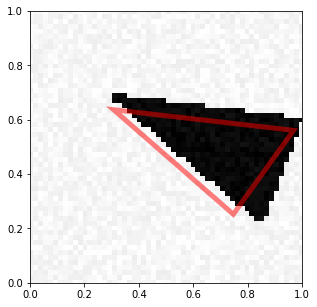

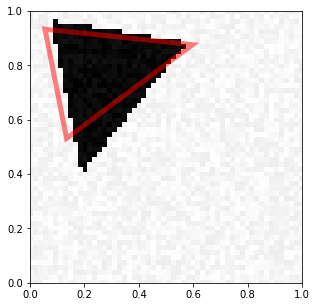

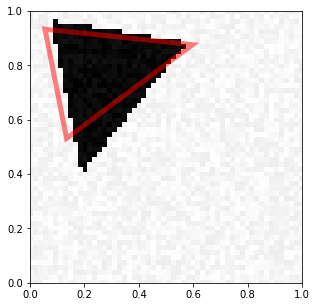

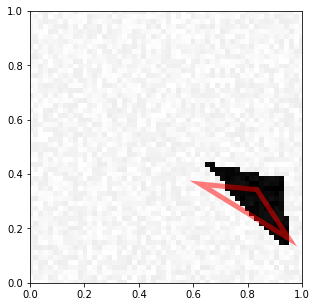

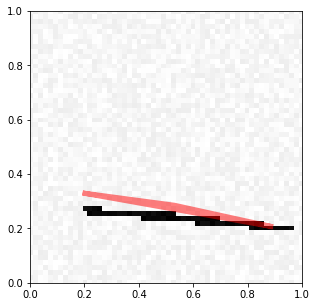

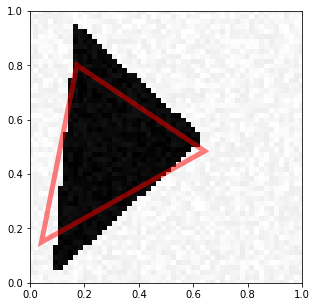

In [53]:
sample = np.random.randint(0,300,10)
for i in sample:
    visualize_prediction(X_test[i], Y_pred[i])

# 7 - Image Denoising

We start modifying the generate_a_* functions to generate pairs of images, where one image has noise with random amplitude, and the second image has the same content but without the noise.

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_couple(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return (generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0))


def generate_a_disk_couple(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return (generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0))

def generate_a_triangle_couple(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return (imdata, generate_a_drawing(figsize, U, V, 0))




In [64]:
def generate_dataset_Denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_couple()[0].shape[0]
    X_noise = np.zeros([nb_samples,im_size])
    Y_denoise = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X_noise[i],Y_denoise[i] = generate_a_rectangle_couple(noise, free_location)
        elif category == 1: 
            X_noise[i],Y_denoise[i] = generate_a_disk_couple(noise, free_location)
        else:
            X_noise[i],Y_denoise[i] = generate_a_triangle_couple(noise, free_location)
    X_noise = (X_noise + noise) / (255 + 2 * noise)
    Y_denoise /= 255
    return [X_noise, Y_denoise]

def generate_test_set_Denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_Denoising(100, 20, True)
    return [X_test, Y_test]



We generate a training dataset

In [56]:
[X_noise, Y_denoise]= generate_dataset_Denoising(2001, noise=20, free_location=True)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


Visulization of a training set sample.

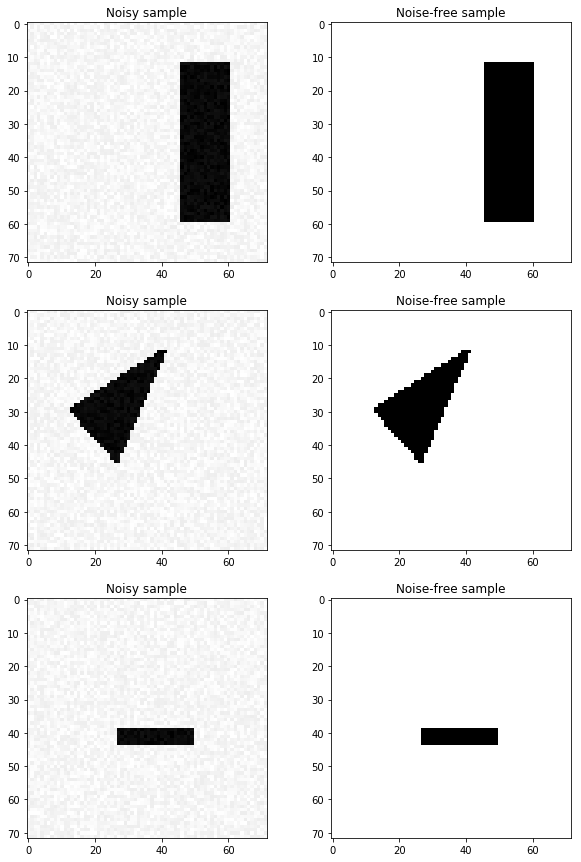

In [59]:
plt.figure(figsize=(10,15))
i=1
while i<=6: 
    plt.subplot(3,2,i)
    plt.title('Noisy sample')
    plt.imshow(X_noise[i].reshape(72,72), cmap='gray')
    plt.subplot(3,2,i+1)
    plt.title('Noise-free sample')
    plt.imshow(Y_denoise[i].reshape(72,72), cmap='gray')
    i+=2
plt.show();

We reshape the training set, and train a CNN :

In [60]:
X_noise = X_noise.reshape(X_noise.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_denoise = Y_denoise.reshape(Y_denoise.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [61]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='linear', input_shape=(72, 72, 1), padding='same'))
model.add(LeakyReLU(alpha=0.1))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2))) 
print(model.output_shape)


model.add(Conv2D(32, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2))) 
print(model.output_shape)

model.add(Conv2D(32, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
print(model.output_shape)

model.add(UpSampling2D((2, 2))) 
print(model.output_shape)

model.add(Conv2D(32, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
print(model.output_shape)

model.add(UpSampling2D((2, 2))) 
print(model.output_shape)


model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
print(model.output_shape)

model.compile(loss='binary_crossentropy', optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=3)
model.fit(X_noise, Y_denoise,
          batch_size=32, epochs=30,verbose=1, validation_split=0.1, callbacks=[early_stopping_monitor]);



(None, 72, 72, 32)
(None, 36, 36, 32)
(None, 36, 36, 32)
(None, 18, 18, 32)
(None, 18, 18, 32)
(None, 36, 36, 32)
(None, 36, 36, 32)
(None, 72, 72, 32)
(None, 72, 72, 1)
Train on 1800 samples, validate on 201 samples
Epoch 1/30
1800/1800 [==============================] - 83s 46ms/step - loss: 5.3529 - val_loss: 0.7058
Epoch 2/30
1800/1800 [==============================] - 82s 45ms/step - loss: 0.5430 - val_loss: 0.4803
Epoch 3/30
1800/1800 [==============================] - 76s 42ms/step - loss: 0.3795 - val_loss: 0.3197
Epoch 4/30
1800/1800 [==============================] - 76s 42ms/step - loss: 0.2782 - val_loss: 0.2401
Epoch 5/30
1800/1800 [==============================] - 75s 42ms/step - loss: 0.2129 - val_loss: 0.1944
Epoch 6/30
1800/1800 [==============================] - 74s 41ms/step - loss: 0.1811 - val_loss: 0.1591
Epoch 7/30
1800/1800 [==============================] - 82s 45ms/step - loss: 0.1465 - val_loss: 0.1370
Epoch 8/30
1800/1800 [==============================] -

In [62]:
model.save( '/Users/alimrabeth/Desktop/Master Data Sciences & Business Analytics/Data Sciences Elective courses/Intro Deep Learning/denoising.h5')

Let's visualize some noise-free predictions.
<br> First, we generate a test set, and then predict noise-free samples

In [65]:
[X_noise_test , Y_denoise_test ]= generate_test_set_Denoising()

X_noise_test = X_noise_test.reshape(X_noise_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_denoise_test = Y_denoise_test.reshape(Y_denoise_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

Creating data:
0


In [66]:
Y_denoise_pred = model.predict(X_noise_test)

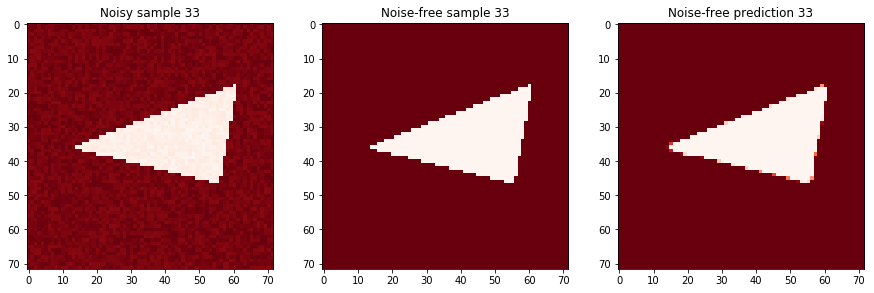

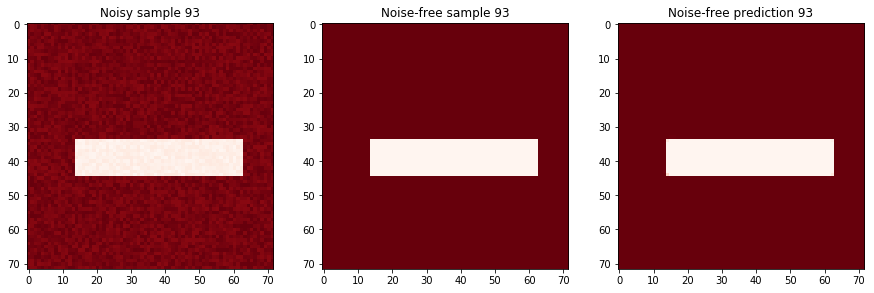

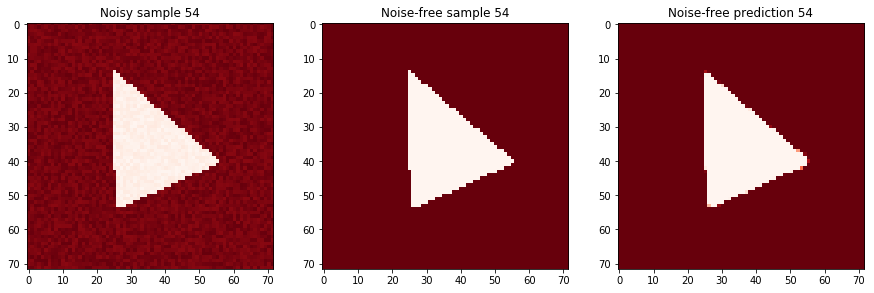

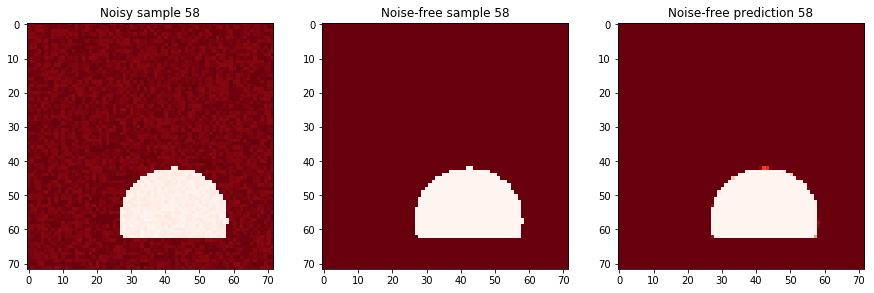

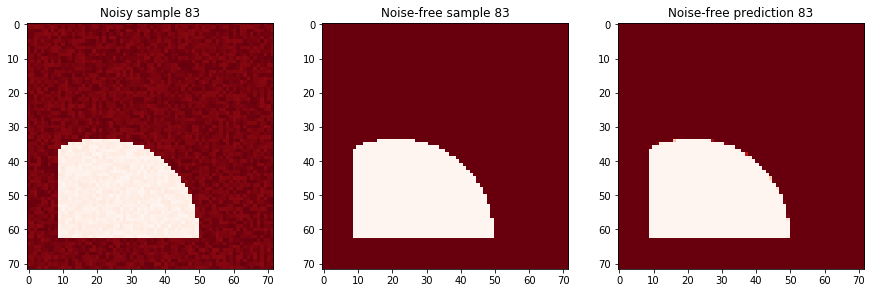

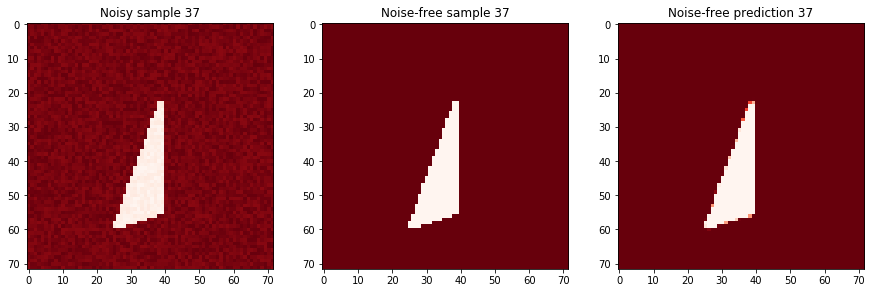

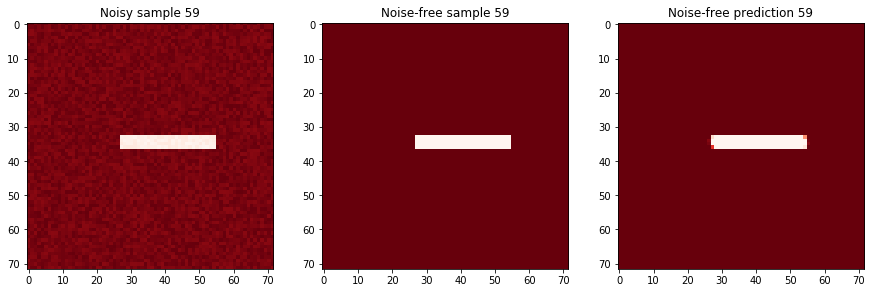

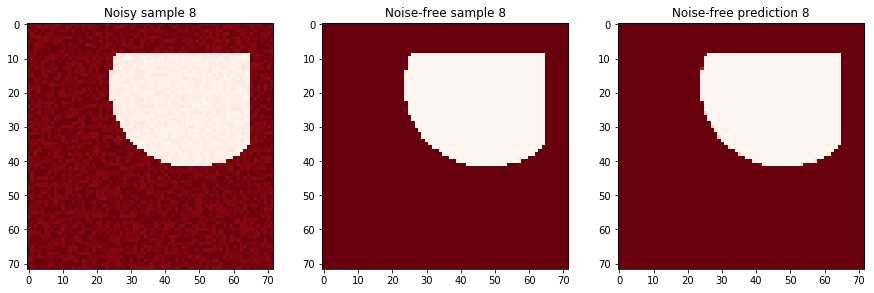

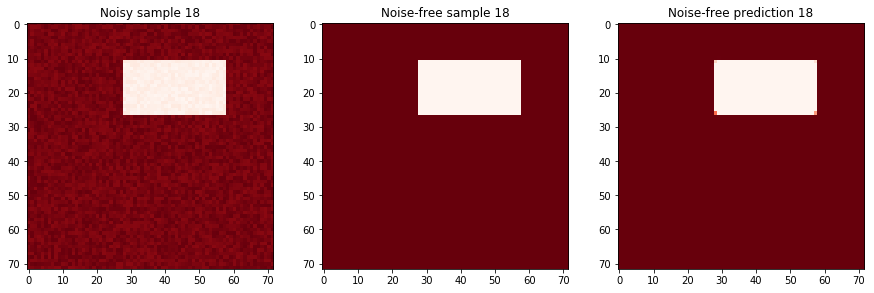

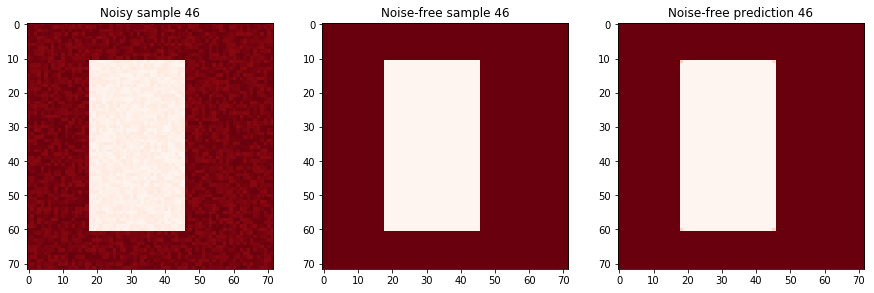

In [67]:
test_size = X_noise_test.shape[0]
sample = np.random.randint(0,test_size,10)
for j in sample:
    plt.figure(figsize = (15,30)).tight_layout
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.subplot(1, 3, 1)
    plt.imshow(X_noise_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)), cmap='Reds')
    plt.title("Noisy sample "+str(j))

    plt.subplot(1, 3, 2)
    plt.imshow(Y_denoise_test[j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Reds')
    plt.title("Noise-free sample "+str(j) )

    plt.subplot(1, 3, 3)
    plt.imshow(Y_denoise_pred[j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Reds')
    plt.title("Noise-free prediction "+str(j))